In [1]:
# Install libraries you don't have 
import sys
!{sys.executable} -m pip install Pillow pandas scikit-learn joblib cv 

In [2]:
import numpy as np 
import pandas as pd 
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D

Using TensorFlow backend.


In [3]:
data = []
labels = []
class_size = 43

for file in range(class_size) :
    path = "./Dataset/Train/{0}/".format(file)
    Class = os.listdir(path)
    for c in Class:
        try:
            image = cv2.imread(path + c)
            image_from_array = Image.fromarray(image, 'RGB')
            resized_image = image_from_array.resize((30, 30))
            resized_images = np.array(resized_image)
            data.append(resized_images)
            labels.append(file)
        except AttributeError:
            print(" ")

In [4]:
Images=np.array(data)
labels=np.array(labels)

In [5]:
# Shuffling the data 
value = np.arange(Images.shape[0])
np.random.seed(class_size)
np.random.shuffle(value)
Images = Images[value]
labels = labels[value]
image_data = len(Images)
labels_data = len(labels)

Training:  (31368, 30, 30, 3)
Testing : (7841, 30, 30, 3)


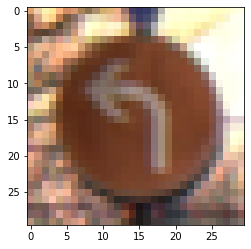

Size of this image is (30, 30, 3)


In [6]:
# Spliting the images into train and validation sets 
(training_images, validation_images) = Images[(int)(0.2 * labels_data):], Images[:(int)(0.2 * labels_data)]
training_images = training_images.astype('float32') / 255 
validation_images = validation_images.astype('float32') / 255
(training_labels, validation_labels) = labels[(int)(0.2 * labels_data):], labels[:(int)(0.2 * labels_data)]
print("Training: ", training_images.shape)
print("Testing :", validation_images.shape)
plt.imshow(training_images[0])
plt.show()
print("Size of this image is " + str(training_images[0].shape))

In [7]:
# Using one hot encoding for the labels
from keras.utils import to_categorical
training_labels = to_categorical(training_labels, class_size)
validation_labels = to_categorical(validation_labels, class_size)

In [8]:
# Define a Callback class that stops training once accuracy reaches 97%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [29]:
# DNN Model 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu', input_shape = training_images.shape[1:]),
    tf.keras.layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape = training_images[1:]),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(class_size, activation='softmax')
])

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        2432      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)         

In [32]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

history = model.fit(training_images, 
                    training_labels, 
                    validation_data = (validation_images, validation_labels), 
                    batch_size = 32, 
                    epochs = 20,
                    verbose = 1,
                    callbacks = [callbacks])

Train on 31368 samples, validate on 7841 samples
Epoch 1/20
31368/31368 [==============================] - 93s 3ms/sample - loss: 1.1474 - accuracy: 0.6759 - val_loss: 0.2069 - val_accuracy: 0.9424
Epoch 2/20
31368/31368 [==============================] - 92s 3ms/sample - loss: 0.1716 - accuracy: 0.9482 - val_loss: 0.1000 - val_accuracy: 0.9746
Epoch 3/20
31360/31368 [============================>.] - ETA: 0s - loss: 0.0914 - accuracy: 0.9721
Reached 97% accuracy so cancelling training!
31368/31368 [==============================] - 88s 3ms/sample - loss: 0.0914 - accuracy: 0.9721 - val_loss: 0.0482 - val_accuracy: 0.9871


In [33]:
test = pd.read_csv("./Dataset/Test.csv")
test_labels = test['Path'].to_numpy()
test = test['ClassId'].values
test_dataset = []
for label in test_labels:
    img = cv2.imread('./Dataset/Test/' + label.replace('Test/', ''))
    image_array = Image.fromarray(img, 'RGB')
    resized_image = image_array.resize((30, 30))
    test_dataset.append(np.array(resized_image))
test_data = np.array(test_dataset)
test_data = test_data.astype('float32')/255
prediction = model.predict_classes(test_data)

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(test, prediction)

0.9320665083135392

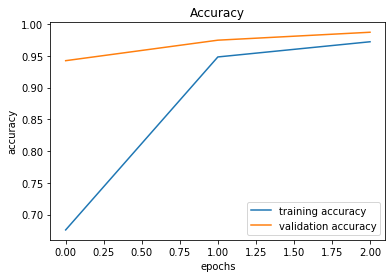

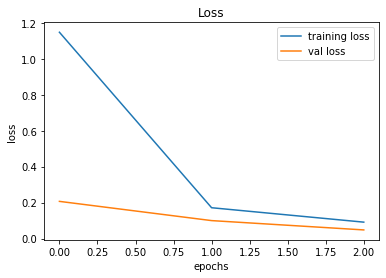

In [35]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


In [44]:
img = cv2.imread('./Dataset/Test/00000.png')
image_array = Image.fromarray(img, 'RGB')
resized_image = image_array.resize((30, 30))
test_dataset.append(np.array(resized_image))
test_data = np.array(test_dataset)
test_data = test_data.astype('float32')/255
prediction = model.predict_classes(test_data)


[16  1 38 ... 16 16 16]
